In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

pgf_with_rc_fonts = {
    "font.family": "serif",
}
mpl.rcParams.update(pgf_with_rc_fonts)

import pandas as pd
import sys
#import numba
#from numba.experimental import jitclass
import sympy, sympy.functions.special
import scipy
import pickle
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
import scipy.interpolate
import scipy.optimize
import itertools
import imageio,os

import cheetah, importlib
importlib.reload(cheetah)

%matplotlib notebook

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Define the time-domain moments

In [3]:
def intJ(x0,sig,m):
    return 1/(m+1)*((x0+sig/2)**(m+1)-(x0-sig/2)**(m+1))
    
def intr(x0,sig,m):
    if m < 2:
        return 0
    else:
        return -m*((sig/2+x0)**(m-1)-(-sig/2+x0)**(m-1))
        
def Cj(a1,a2,a3,x1,x2,w,h):
    x1 += w/2
    x2 += h/2
    return intJ(x1,w,a1)*intJ(x2,h,a2)

def Cr(a1,a2,a3,x1,x2,w,h):
    x1 += w/2
    x2 += h/2
    return intr(x1,w,a1)*intJ(x2,h,a2)

<IPython.core.display.Javascript object>


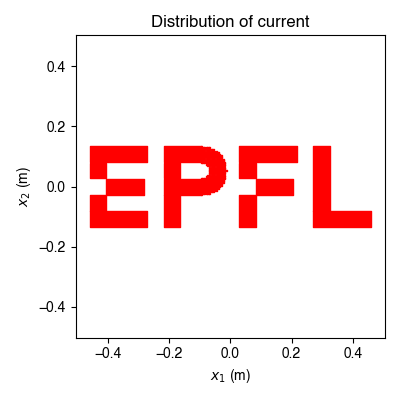

In [13]:
case_ = "logo"

mu = 4*np.pi*1e-7
gamma_SI = 4e-9 # COMSOL: 4 ns
gamma = 1
c0 = 299792458*gamma_SI

Tg    = np.sqrt(7/12)
lambd = c0*Tg
match case_:
    case "logo":
        a = lambd/2
    case "disc":
        a = lambd*9
    case "rasc":
        a = lambd
        
L = 2*a
Llogo = 171

match case_:
    case "logo":
        margin = 0.1
        #      1.  2.  3.  4.  5.  6.  7.  8.  9.  10. 11. 12. 13.  14.  15.  16.  17.  18.
        x1s = [0,  0,  10, 0,  0,  45, 45, 45, 45, 91, 91, 101, 91,  136, 136]
        x2s = [0,  10, 20, 30, 40, 0,  20, 30, 40, 0,  30, 20,  40,  10,  0]
        ws =  [35, 10, 23, 10, 35, 10, 23, 10, 23, 10, 10, 23,  35,  10,  35]
        hs =  [10, 10, 10, 10, 10, 20, 10, 10, 10, 20, 10, 10,  10,  40,  10]

        d1 = a
        d2 = a*50/Llogo
        
        w0 = 1
        h0 = 1
        x10 = np.arange(0,171,w0)
        x20 = np.arange(0,171,h0)
        for xi,yi in itertools.product(x10,x20):
            if (xi-68)**2+(yi-35)**2 <= 15**2 and xi>=68\
                and (xi-68)**2+(yi-35)**2 >= 5**2:
                x1s.append(xi-w0/2)
                x2s.append(yi-h0/2)
                ws.append(w0)
                hs.append(h0)
        t = np.linspace(0,10*gamma,200)
        
    case ("disc"|"rasc"):
        margin = 1
        d1 = a
        d2 = a
        x1s,x2s,ws,hs = [],[],[],[]
        w0 = 4
        h0 = 4
        x10 = np.arange(0,171,w0)
        x20 = np.arange(0,171,h0)
        for xi,yi in itertools.product(x10,x20):
            if (xi-171/2)**2+(yi-171/2)**2 <= (171/2-w0/2)**2*1.1:
                x1s.append(xi-w0/2)
                x2s.append(yi-h0/2)
                ws.append(w0)
                hs.append(h0)
        match case_:
            case "disc":
                t = np.linspace(0,6*gamma,200)
            case "rasc":
                t = np.linspace(0,10*gamma,300)

def current_moment(a1,a2,a3):
    moment = 0
    if a3 == 0:
        for xi,yi,wi,hi in zip(x1s,x2s,ws,hs):
            moment += Cj(a1,a2,a3,xi/Llogo*L-d1,yi/Llogo*L-d2,wi/Llogo*L,hi/Llogo*L)/gamma_SI
    return [moment,0,0]
            
def charge_moment(a1,a2,a3):
    moment = 0
    if a3 == 0:
        for xi,yi,wi,hi in zip(x1s,x2s,ws,hs):
            moment += Cr(a1,a2,a3,xi/Llogo*L-d1,yi/Llogo*L-d2,wi/Llogo*L,hi/Llogo*L)/gamma_SI
    return [moment,0,0]

    
fig, ax = plt.subplots(figsize=(4,4))
plt.rcParams["font.family"] = "helvetica"

boxes = [patches.Rectangle((x/Llogo*L-d1,y/Llogo*L-d2),(w-margin)/Llogo*L,(h-margin)/Llogo*L)
         for x, y, w, h in zip(x1s, x2s, ws, hs)]

# Create patch collection with specified colour/alpha
pc = PatchCollection(boxes,color="r")

#if case_ == "disc":
#    ax.add_collection(PatchCollection([patches.Circle((0,0),a)],color=(1,.7,0)))
ax.add_collection(pc)

if False:
    i=1
    for x, y, w, h in zip(x1s, x2s, ws, hs):
        plt.text(x/Llogo*L-d1,y/Llogo*L-d2,f"{i}")
        i+=1

#plt.vlines(0,-a,a,color="g")
#plt.hlines(0,-a,a,color="g")

plt.title("Distribution of current")

plt.xlim((-a*1.1,a*1.1))
plt.ylim((-a*1.1,a*1.1))

plt.xlabel("$x_1$ (m)")
plt.ylabel("$x_2$ (m)")

plt.tight_layout()

plt.savefig(f"../figures/current-{case_}.pdf")

In [14]:
x1    = np.array([0,])
x2    = np.array([0,])
match case_:
    case "logo":
        x3 = np.array((2,3,1000,))*a
    case ("disc"|"rasc"):
        x3 = np.array((3,9,18,))*a

t_sym = sympy.Symbol("t",real=True)
gamma_sym = sympy.Symbol("gamma",real=True)
h_sym = (3*gamma_SI*sympy.sqrt(np.pi/2))**-.5\
    *sympy.exp(-((t_sym-3*gamma)/gamma)**2)*(4*((t_sym-3*gamma)/gamma)**2-2)


importlib.reload(cheetah)

sol = cheetah.Solution(max_order=24, wave_speed=c0)
sol.recurse()
sol.set_moments(current_moment=current_moment,
                charge_moment=charge_moment)
match case_:
    case "logo":
        E = sol.compute_E_field(x1,x2,x3,t,
                            h_sym,t_sym,
                               verbose=True)
    case ("disc"|"rasc"):
        E = sol.compute_E_field(x1,x2,x3,t,
                            h_sym,t_sym,
                                verbose=True,
                               delayed=False)

E1 = E[0,:,:,:,:]

Computing order 24...Done.
Computing derivative of order 26...Done.
Computing index [ 0 21  0]...

<lambdifygenerated-345>:2: RuntimeWarning: underflow encountered in exp
  return (65233.3068629971*t - 2*(t - 3)*(32616.6534314986*(t - 3)**2 - 16308.3267157493) - 195699.920588991)*exp(-(t - 3)**2)
<lambdifygenerated-346>:2: RuntimeWarning: underflow encountered in exp
  return (130466.613725994*t**4 - 1565599.36471193*t**3 + 6653797.30002571*t**2 - 11741995.2353395*t + 7143047.10149819)*exp(-t**2 + 6*t - 9)
<lambdifygenerated-347>:2: RuntimeWarning: underflow encountered in exp
  return (-260933.227451989*t**5 + 3913998.41177983*t**4 - 22179324.333419*t**3 + 58709976.1766974*t**2 - 71430471.0149819*t + 31116287.3736496)*exp(-t**2 + 6*t - 9)
<lambdifygenerated-348>:2: RuntimeWarning: underflow encountered in exp
  return (521866.454903977*t**6 - 9393596.18827159*t**5 + 66537973.0002571*t**4 - 234839904.70679*t**3 + 428582826.089891*t**2 - 373395448.483796*t + 115267253.226916)*exp(-t**2 + 6*t - 9)
<lambdifygenerated-349>:2: RuntimeWarning: underflow encountered in exp
  return (-10437

Computing index [ 1 21  0]...

Computing index [ 2 14  0]...

<lambdifygenerated-343>:2: RuntimeWarning: underflow encountered in exp
  return 1.0*(48924.9801472479 - 16308.3267157493*t)*exp(-(t - 3)**2)
<lambdifygenerated-344>:2: RuntimeWarning: underflow encountered in exp
  return 8154.16335787464*(4*(t - 3)**2 - 2)*exp(-(t - 3)**2)


Computing index [24  0  0]...Done.


<IPython.core.display.Javascript object>


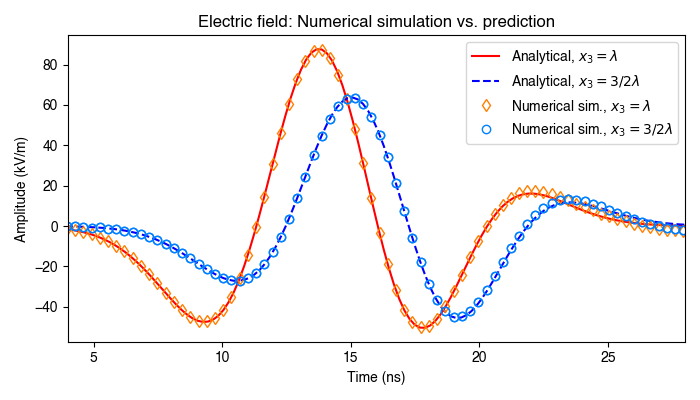

In [15]:
match case_:
    case "logo":
        fname = "../../timeDomainDerivation_Part2/data/Efield_at_2a_and_3a_lambdaOver2_v3.txt"
        data_cmsl = pd.read_csv(fname,
                        skiprows=range(10),
                        names=("t","absE2a","E2a","absE3a","E3a"),
                        delim_whitespace=True)
        Nd = 4 
    case "disc":
        fname = "../data/ratio-0-5-v6.txt"
        data_cmsl = pd.read_csv(fname,
                        skiprows=range(10),
                        names=("t","absE2a","E2a"),
                        delim_whitespace=True)

plt.figure(figsize=(7,4))
plt.rcParams["font.family"] = "helvetica"

match case_:
    case "logo":
        plt.plot(t*gamma_SI*1e9,E1[0,0,0,:].T/1e3,color=(1,0,0))
        plt.plot(t*gamma_SI*1e9,E1[0,0,1,:].T/1e3,'--',color=(0,0,1))
        plt.plot(data_cmsl["t"][::Nd]*1e9,data_cmsl["E2a"][::Nd]/1e3/2,'d',#-3.77*gamma_SI*1e9
                color=(1,.5,0),mfc="none")
        plt.plot(data_cmsl["t"][::Nd]*1e9,data_cmsl["E3a"][::Nd]/1e3/2,'o',#-4.15*gamma_SI*1e9
                color=(0,0.5,1),mfc="none")
        plt.plot(data_cmsl["t"][::Nd]*1e9,data_cmsl["E3a"][::Nd]/1e3/2,'o',
                color=(0,0.5,1),mfc="none")
        plt.legend(("Analytical, $x_3=\lambda$","Analytical, $x_3=3/2\lambda$",
                    "Numerical sim., $x_3=\lambda$","Numerical sim., $x_3=3/2\lambda$"))
        plt.title("Electric field: Numerical simulation vs. prediction")
        plt.xlim((1*gamma_SI*1e9,7*gamma_SI*1e9))
        plt.ylabel("Amplitude (kV/m)",font="helvetica")
        plt.xlabel("Time (ns)",font="helvetica")
        plt.tight_layout()
        plt.savefig("../figures/analytical_vs_COMSOL.pdf")
        
    case "disc":
        Nd = 2
        d = pd.read_csv("../data/data_paper.csv",
               skiprows=1)
        plt.plot(t[::Nd]*gamma_SI*1e9,E1[0,0,0,::Nd].T*x3[0]/1e6,'.',color=(1,0,0))
        plt.plot(t*gamma_SI*1e9,E1[0,0,1,:].T*x3[1]/1e6,"--",color=(0,1,0))
        plt.plot(t*gamma_SI*1e9,E1[0,0,2,:].T*x3[2]/1e6,color=(0,0,1))
        plt.xlim((0*gamma_SI*1e9,6*gamma_SI*1e9))
        delay = -3*gamma_SI*1e9
        plt.plot(d["X.2"]*Tg*gamma_SI*1e9-delay,d["Y.2"]*100,'o',
                 color=(1,0,0),mfc="none")
        plt.plot(d["X.1"]*Tg*gamma_SI*1e9-delay,d["Y.1"]*100,'d',
                 color=(0,1,0),mfc="none")
        plt.plot(d["X"]*Tg*gamma_SI*1e9-delay,d["Y"]*100,'s',
                 color=(0,0,1),mfc="none")
        
        plt.legend(("Approx., $x_3=27\lambda$",
                    "Approx., $x_3=81\lambda$",
                    "Approx., $x_3=162\lambda$",
                    "True, $x_3=27\lambda$",
                    "True, $x_3=81\lambda$",
                    "True, $x_3=162\lambda$"),loc="upper left")
        
        plt.ylabel("Amplitude (MV)",font="helvetica") 
        plt.xlabel("Time (ns)",font="helvetica")
        plt.title("Electric field: Approximate vs. true current density")
        
        plt.tight_layout()
        plt.savefig("../figures/approx_vs_disc.pdf")


In [9]:
x1 = np.linspace(-2.5*a,2.5*a)
x2 = np.array([0,])
x3 = np.linspace(0,5*a)
  
importlib.reload(cheetah)

sol = cheetah.Solution(max_order=10, wave_speed=c0)
sol.recurse()

type_ = "simple" # simple | complex

def simple_mom_r(a1,a2,a3):
    if a1==0 and a2==0 and a3==0:
        return charge_moment(0,0,0)
    else:
        return [0,0,0]
    
def simple_mom_J(a1,a2,a3):
    if a1==0 and a2==0 and a3==0:
        return current_moment(0,0,0)
    else:
        return [0,0,0]
    
def complex_mom_r(a1,a2,a3):
    if a1==0 and a2==0 and a3==10:
        return charge_moment(0,0,0)
    else:
        return [0,0,0]
    
def complex_mom_J(a1,a2,a3):
    if a1==0 and a2==0 and a3==10:
        return current_moment(0,0,0)
    else:
        return [0,0,0]
    
match type_:
    case "simple":
        sol.set_moments(current_moment=simple_mom_J,
                        charge_moment=simple_mom_r)
    case "complex":
        sol.set_moments(current_moment=complex_mom_J,
                charge_moment=complex_mom_r)
        
E = sol.compute_E_field(x1,x2,x3,t,
                    h_sym,t_sym)
E1 = E[0,:,:,:,:]
rho13 = np.sqrt(x1.reshape((x1.size,1))**2+x3.reshape((1,x3.size))**2)
E1[rho13.reshape(1,x1.size,x3.size)<1.1*a,:]=np.nan
absE = np.sum(E**2,axis=0)

Computing order 10...Done.


In [12]:
a

0.9158810877079132

<IPython.core.display.Javascript object>


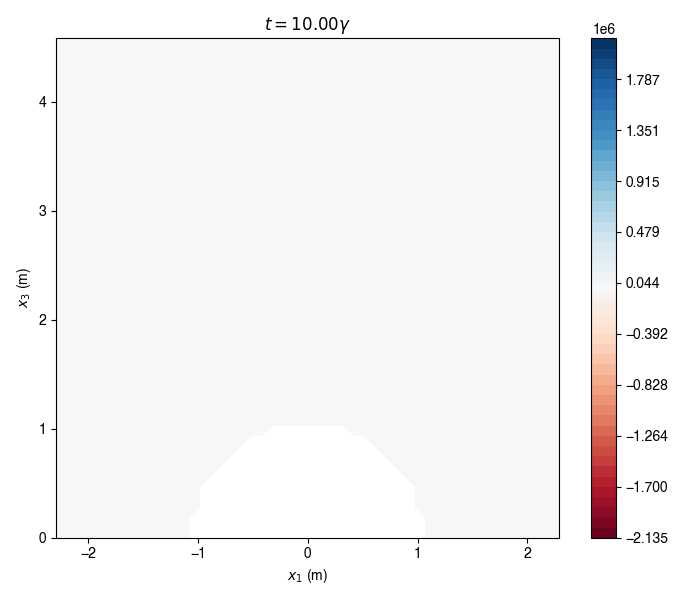

In [10]:
Nd = 1
fnames = [f"../../../papers/at-ap-rasc-2022/pics/{type_}-plane-cut-{ti}.png" for ti in t[::Nd]]
M = np.nanmax(E1)
match type_:
    case "simple":
        scale = 1
    case "complex":
        scale = 1e2

plt.figure(figsize=(7,6))

#for i, (ti,fname) in enumerate(zip(t[::Nd][:1],fnames[:1])):
for i, (ti,fname) in enumerate(zip(t[::Nd],fnames)):
    plt.clf()
    plt.contourf(x1,x3,(E1[0,:,:,i]).transpose(),
                 levels=np.linspace(-M/scale,M/scale),
                 cmap="RdBu")
    plt.colorbar()
    
    current_val = sympy.lambdify(t_sym,h_sym)(ti)/200
    if current_val > 0:
        plt.plot(0,0,'b|',
                markersize=abs(current_val))
    else:
        plt.plot(0,0,'r|',
                markersize=abs(current_val))    
        
    plt.title(f"$t = {t[i]:.2f} \gamma $")
    plt.xlabel("$x_1$ (m)")
    plt.ylabel("$x_3$ (m)")
    
    plt.tight_layout()
    plt.savefig(fname)

In [259]:
with imageio.get_writer(f"../../../papers/at-ap-rasc-2022/{type_}-plane-cut.gif", 
                        mode='I',
                       fps=30) as writer:
    for filename in fnames:
        image = imageio.imread(filename)
        writer.append_data(image)

In [97]:
for f in fnames:
    if os.path.isfile(f): # this makes the code more robust
        os.remove(f)

-----------
Initializing structure...
time for choose_chunkdivision = 0.000159025 s
Working in 2D dimensions.
Computational cell is 16 x 8 x 0 with resolution 10
     block, center = (0,0,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.0129199 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (4000 timesteps)


<IPython.core.display.Javascript object>


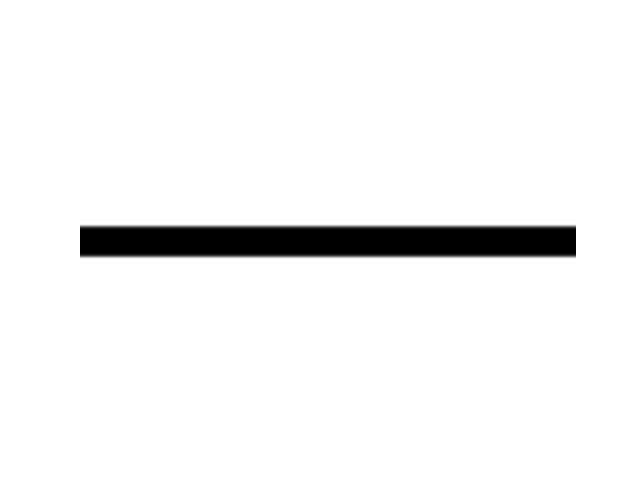

<IPython.core.display.Javascript object>


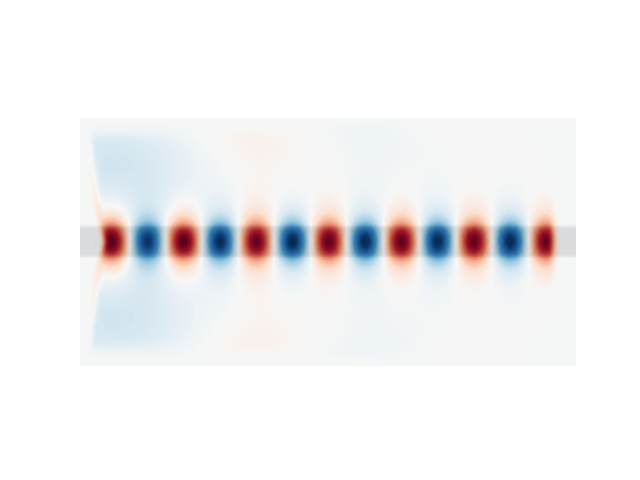

(-0.5, 159.5, 79.5, -0.5)

In [372]:
cell = mp.Vector3(16,8,0)
geometry = [mp.Block(mp.Vector3(mp.inf,1,mp.inf),
                     center=mp.Vector3(),
                     material=mp.Medium(epsilon=12))]
sources = [mp.Source(mp.ContinuousSource(frequency=0.15),
                     component=mp.Ez,
                     center=mp.Vector3(-7,0))]
pml_layers = [mp.PML(1.0)]
resolution = 10
sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=sources,
                    resolution=resolution)
sim.run(until=200)

eps_data = sim.get_array(center=mp.Vector3(), size=cell, component=mp.Dielectric)
plt.figure()
plt.imshow(eps_data.transpose(), interpolation='spline36', cmap='binary')
plt.axis('off')

ez_data = sim.get_array(center=mp.Vector3(), size=cell, component=mp.Ez)
plt.figure()
plt.imshow(eps_data.transpose(), interpolation='spline36', cmap='binary')
plt.imshow(ez_data.transpose(), interpolation='spline36', cmap='RdBu', alpha=0.9)
plt.axis('off')


In [368]:
pml_layers

In [1116]:
cmd = "sed 's/% //g' Efield_lambdaOver2.txt | sed 's/ \{2,\}/\,/g' | sed 's/ emw./,emw./g' > Efield_lambdaOver2rep2.txt"
if False:
    cmsl_mesh = pd.read_csv("../COMSOL/Efield_lambdaOver2.txt",
                skiprows=range(8),
                #names = ["x","y","z"],
                #delim_whitespace=True,
                dtype="float")
cmsl_mesh.shape

(29913, 1511)

In [1117]:
def get_at_pos(a,b,c,thresh=0.01):
    ix = np.abs(cmsl_mesh["% x"]-a)<thresh
    iy = np.abs(cmsl_mesh["y"]-b)<thresh
    iz = np.abs(cmsl_mesh["z"]-c)<thresh
    cmsl_extract = cmsl_mesh[ix&iy&iz]
    print(f"There are {cmsl_extract.shape[0]} hits")
    if cmsl_extract.shape[0] == 0:
        raise ValueError("No hit! Increase threshold")
    Ex_cols = [col for col in cmsl_mesh.columns if 'Ex' in col]
    return np.array(cmsl_extract[Ex_cols])[0,:-1]

In [54]:
#pickle.dump((t,E1), open("../data/cheetah-ratio-2-no_charge.pickle", "wb"))

In [7]:
data_paper = pd.read_csv("data_paper.csv",
                        skiprows=[0,1],
                        names=("18a,t",
                              "18a,E",
                              "9a,t",
                              "9a,E",
                              "3a,t",
                              "3a,E"))
data_paper["3a,E"] *= 1e8
data_paper["9a,E"] *= 1e8
data_paper["18a,E"] *= 1e8

data_sim = pd.read_csv("ratio-0-5-v6.txt",
                      skiprows=range(7),
                      delim_whitespace=True)
t_sim = data_sim["%"]#[data_sim["%"] == gamma_SI]["gamma"]
E_sim = data_sim["(s)"]#[data_sim["%"] == gamma_SI]["Time"]#

FileNotFoundError: [Errno 2] No such file or directory: 'data_paper.csv'

<IPython.core.display.Javascript object>


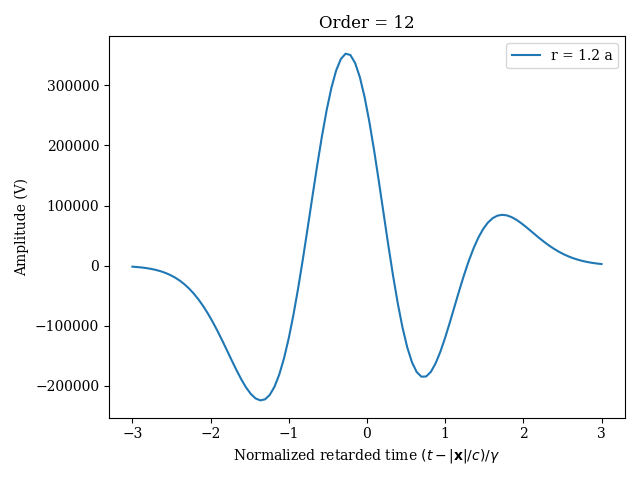

In [40]:
plt.figure()
normalize  = False
show_paper = False
show_sim   = False

delays = {
    1: -4.00,
    0.5: -3.51,
    2: -4.85
}

if show_paper:
    for dist in ["3","9","18"]:
        plt.plot(data_paper[dist+"a,t"]*Tg,data_paper[dist+"a,E"])
if show_sim:
    plt.plot(t_sim/gamma_SI+delays[0.5],E_sim)#/np.max(np.abs(E_sim))) 

        
if normalize or show_sim:
    plt.plot(t,E1[0,0,:,:].T)#/np.max(np.abs(E1[0,0,:,:]),axis=-1))
else:
    plt.plot(t,E1[0,0,:,:].T*x3)
    
if show_paper:  
    plt.legend(["paper, r = {} a".format(d) for d in [3,9,18]]+["r = {:.1f} a".format(xi/a) for xi in x3])
elif show_sim:
    plt.legend(["sim"]+["r = {:.1f} a".format(xi/a) for xi in x3])

else:
    plt.legend(["r = {:.1f} a".format(xi/a) for xi in x3])
    
plt.xlabel("Normalized retarded time $(t-|\mathbf{x}|/c)/\gamma$")
plt.ylabel("Amplitude (V)")
plt.title("Order = {}".format(sol.max_order))
plt.tight_layout()

In [45]:
E_cmsl = {}
data_sim = pd.read_csv("/home/elias/Dropbox/Documents/EPFL/Doctorat/etr/papers/timeDomainDerivation_Part2/ratio-1-v4.txt",
                      skiprows=range(7),
                      delim_whitespace=True)
E_cmsl[1] = (data_sim["%"],data_sim["(s)"])
data_sim = pd.read_csv("/home/elias/Dropbox/Documents/EPFL/Doctorat/etr/papers/timeDomainDerivation_Part2/ratio-0-5-v3.txt",
                      skiprows=range(7),
                      delim_whitespace=True)
E_cmsl[0.5] = (data_sim["%"],data_sim["(s)"])
data_sim = pd.read_csv("/home/elias/Dropbox/Documents/EPFL/Doctorat/etr/papers/timeDomainDerivation_Part2/ratio-2-v1.txt",
                      skiprows=range(7),
                      delim_whitespace=True)
E_cmsl[2] = (data_sim["%"],data_sim["(s)"])

In [19]:
E_sims = dict()
# keys: (a/c/T, using charge?)

In [44]:
E_sims[(2,use_charge)] = E1

<IPython.core.display.Javascript object>


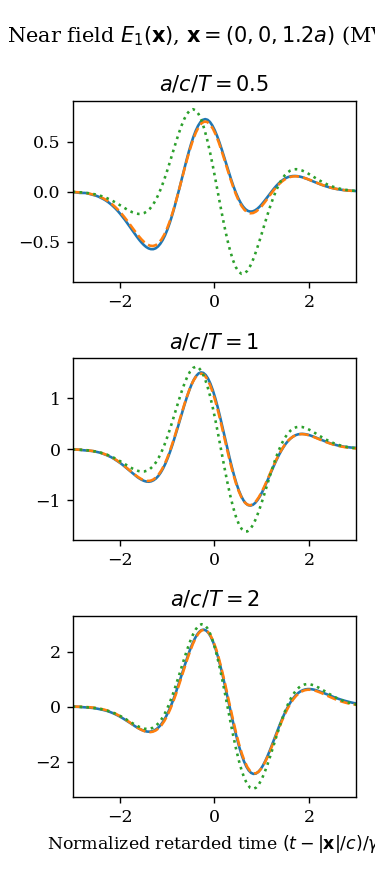

In [61]:
plt.figure(figsize=(3,7))

for ratio,index in zip([0.5,1,2],[1,2,3]):
    plt.subplot(1,3,index)
    plt.plot(E_cmsl[ratio][0]/gamma_SI+delays[ratio],E_cmsl[ratio][1]/1e6)
    plt.plot(t,E_sims[(ratio,True)][0,0,0,:]/1e6,"--")
    plt.plot(t,E_sims[(ratio,False)][0,0,0,:]/1e6,":")
    plt.xlim((-3,3))
    
    if index == 3:
        plt.xlabel("Normalized retarded time $(t-|\mathbf{x}|/c)/\gamma$")
    if index == 1:
        plt.title("Near field $E_1(\mathbf{x})$, $\mathbf{x}=(0,0,1.2a)$ (MV/m) \n\n$a/c/T = "+"{}$".format(ratio))
    else:
        plt.title("$a/c/T = {}$".format(ratio))
            
   # if index == 2:
  #      plt.legend(("Simulation","Charge","No charge"),
  #                )

plt.tight_layout()
plt.savefig('near_field.pgf', format='pgf')

<IPython.core.display.Javascript object>


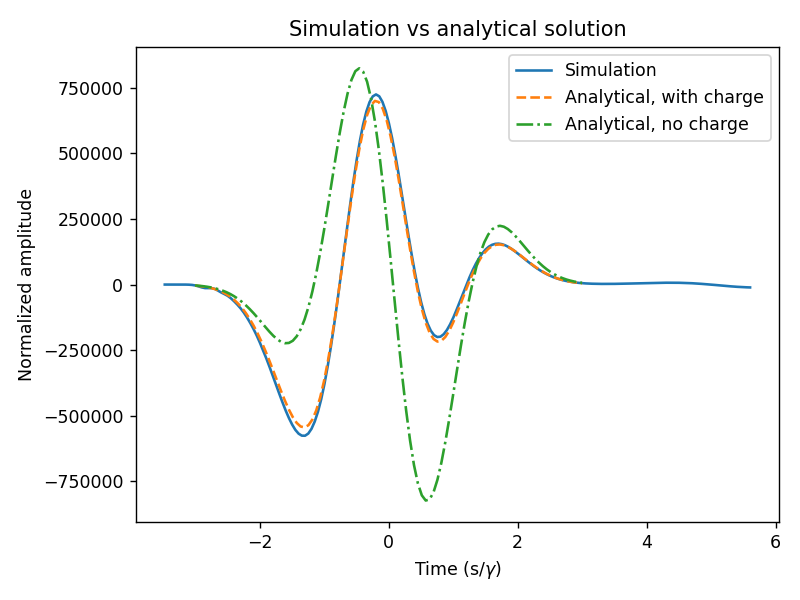

In [28]:
plt.figure()
plt.plot(t_sim/gamma_SI-3.47,E_sim)
plt.plot(t,E_charge[0,0,0,:],'--')
plt.plot(t,E_no_charge[0,0,0,:],'-.')
plt.xlabel("Time (s/$\gamma$)")
plt.ylabel("Normalized amplitude")
plt.title("Simulation vs analytical solution")
plt.legend(["Simulation","Analytical, with charge","Analytical, no charge"])
plt.tight_layout()